In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import interactive
from matplotlib import colors
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
from math import exp
import matplotlib.ticker as ticker

In [2]:
AVD_data = pd.read_csv('raw_data/Adventdalen_Hour.dat', 
	skiprows = [0,2,3],index_col = 0,parse_dates = True, na_values = 'NAN', header = 0 ,
	names = ['TIMESTAMP','RECORD','ID','T2m_PT1000_Max','T2m_PT1000_Min','T2m_PT1000_Avg',
	'T10m_PT1000_Max','T10m_PT1000_Min','T10m_PT1000_Avg',
	'T2m_Rotron_Max','T2m_Rotron_Min','T2m_Rotron_Avg',
	'LF2m_Rotron_Max','LF2m_Rotron_Avg','T10m_Rotron_Max',
	'T10m_Rotron_Min', 'T10m_Rotron_Avg', 'LF10m_Rotron_Max',
	'LF10m_Rotron_Avg','p_mbar','ff2m_mps_Max','ff2m_10min',
	'ff2m_mps_avg', 'dd2m', 'ff10m_sek_Max', 'ff10m_10min',
	'ff10m_mps_Avg','dd10m','Batt_V_Min'])

# Import data from radiation measurements Adventdalen 
AVD_rad_all = pd.read_csv('raw_data/Adventdalen_New_Fem_minutt.dat', 
	skiprows = [0,2,3],index_col = 0, parse_dates = True, na_values = 'NAN',header = 0,
	names = ['TIMESTAMP','RECORD','SWin_Wpm2','LWin_Wpm2','SWout_Wpm2','LWout_Wpm2','CNR1_temp_gr_C_Avg'])

# Radiaton data is available in 5min steps, create hourly mean values of the radiation components. 
# shift(1) - shift the whole dataset by one timestep so that a value at each timestep is the mean of the previous hour
AVD_rad_data = pd.DataFrame.from_dict({
	'SWin_Wpm2':AVD_rad_all['SWin_Wpm2'].resample('H').mean().shift(1), #opp..upward looking instrument measuring SW down
	'SWout_Wpm2': AVD_rad_all['SWout_Wpm2'].resample('H').mean().shift(1), #ned..downward looking instrument measuring SW up
	'LWin_Wpm2': AVD_rad_all['LWin_Wpm2'].resample('H').mean().shift(1),
	'LWout_Wpm2': AVD_rad_all['LWout_Wpm2'].resample('H').mean().shift(1)})
# Import data from AWS Gruvefjellet (GF)
GF_data = pd.read_csv('raw_data/Gruvefjellet_Res_data.dat', 
	skiprows = [0,2,3], index_col = 0,parse_dates = True, na_values = 'NAN', header = 0 ,
	names = ['TIMESTAMP','RECORD','ID','T10cm_minutt_Max','T10cm_minutt_Min','T10cm_minutt_Avg',
	'T1m_minutt_Max','T1m_minutt_Min','T1m_minutt_Avg',
	'T3m_minutt_Max','T3m_minutt_Min','T3m_minutt_Avg',
	'LF_minutt_Max','LF_minutt_Avg','p_mbar','ff_mps_Max','ff_10min',
	'ff_mps_avg', 'dd','NB_time','SD_m','SD_kval','TSS','T_soil_1m',
	'T_soil_2m','T_soil_3m','T_soil_4m','T_soil_5m','T_soil_6m',
	'R_surf_ohm','R_1m_ohm', 'R_2m_ohm', 'R_3m_ohm', 'R_4m_ohm',
	'R_5m_ohm', 'R_6m_ohm', 'Batt_V_Min'])

# Import ERA5 precipitation data
ERA5_all = pd.read_csv('data/ERA5_GF.txt', index_col = 0, parse_dates = True,
	na_values = 'NaN', header = 0, names = ['TIMESTAMP', 'HS', 'RR', 'RRmm',
	'T2m', 'ptype'])
# eklima precipitation data
eklima_LFH_RR_all = pd.read_csv('data/LFH_RR_ts.txt', index_col=0,parse_dates = True,
na_values='NaN',header=0, names= ['RR','ff'])
eklima_AVD_RR_all = pd.read_csv('data/AVD_RR_ts.txt', index_col=0,parse_dates = True,
na_values='NaN',header=0, names= ['RR','ff'])
eklima_LFH_T_all = pd.read_csv('data/LFH_T_ts.txt', index_col=0,parse_dates = True,
na_values='NaN',header=0, names= ['T'])
eklima_AVD_T_all = pd.read_csv('data/AVD_T_ts.txt', index_col=0,parse_dates = True,
na_values='NaN',header=0, names= ['T'])

In [3]:
GF_data = GF_data['2016-08-01 00:00:00':'2017-04-30 23:00:00']			 	
AVD_rad_data = AVD_rad_data['2016-08-01 00:00:00':'2017-04-30 23:00:00'] 
AVD_data = AVD_data['2016-08-01 00:00:00':'2017-04-30 23:00:00']
eklima_LFH_RR = eklima_LFH_RR_all['2016-08-01 06:00:00':'2017-04-30 23:00:00']
eklima_AVD_RR = eklima_AVD_RR_all['2016-08-01 06:00:00':'2017-04-30 23:00:00']
eklima_LFH_T = eklima_LFH_T_all['2016-08-01 00:00:00':'2017-04-30 23:00:00']
eklima_AVD_T = eklima_AVD_T_all['2016-08-01 00:00:00':'2017-04-30 23:00:00']
ERA5 = ERA5_all['2016-08-01 06:00:00':'2017-04-30 23:00:00']

In [4]:
Tdiff_GFAVD_3m2mRot = GF_data.T3m_minutt_Avg - AVD_data.T2m_Rotron_Avg
Tdiff_GFAVD_3m2mPT = GF_data.T3m_minutt_Avg - AVD_data.T2m_PT1000_Avg
Tgrad_GFAVD_3m2mRot = Tdiff_GFAVD_3m2mRot/(464-15)*100
Tgrad_GFAVD_3m2mPT = Tdiff_GFAVD_3m2mPT/(464-15)*100

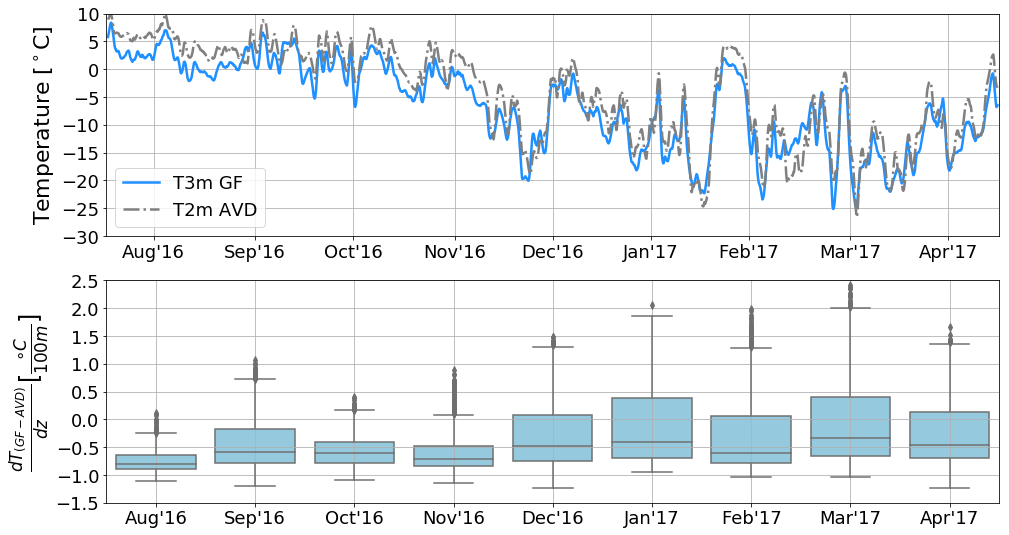

In [5]:
f9, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (16,9))
maxGF = max(GF_data.T3m_minutt_Avg)
date_maxGF = GF_data.T3m_minutt_Avg.idxmax()
date_minGF = GF_data.T3m_minutt_Avg.idxmin()
# print(date_maxGF,date_minGF)
maxAVD = max(AVD_data.T2m_PT1000_Avg)
date_maxAVD = AVD_data.T2m_PT1000_Avg.idxmax()
date_minAVD = AVD_data.T2m_PT1000_Avg.idxmin()
# print(date_maxAVD,date_minAVD)


dTind = GF_data.index
xticks=[]
dates = ['2016-08-15 12:00:00','2016-09-15 12:00:00','2016-10-15 12:00:00','2016-11-15 12:00:00','2016-12-15 12:00:00',
        '2017-01-14 12:00:00','2017-02-13 12:00:00','2017-03-16 12:00:00','2017-04-15 12:00:00',]
for counter, value in enumerate(dTind):
    if str(value) in dates:
        xticks.append(counter)

ax1.grid()
data = pd.DataFrame.from_records({"GF":GF_data.T3m_minutt_Avg.tolist(),'AVD':AVD_data.T2m_PT1000_Avg.tolist()})
ax1.plot(data.index, data.GF.rolling(24,center=True).mean(),color="#1E90FF",linestyle='-',linewidth=2.5, label = "T3m GF")
ax1.plot(data.index, data.AVD.rolling(24,center=True).mean(),color ="#808080",linestyle='-.', linewidth=2.5, label = "T2m AVD")
ax1.set_ylabel("Temperature [$^\circ$C]",fontsize =22)
ax1.set_ylim((-30,10))
ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
ax1.set_yticks(np.arange(-30,11,5))
ax1.set_xlim((0,len(data.index)))
# ax1.tick_params(axis='x',which='minor', bottom = False)
# ax1.xaxis.set_minor_locator(AutoMinorLocator)
ax1.set_xticks(ticks=xticks)
# ax1.set_xticklabels(['2016-08-01','2016-09-01','2016-10-01','2016-11-01','2016-12-01',
#         '2017-01-01','2017-02-01','2017-03-01','2017-04-01'])
ax1.set_xticklabels(['Aug\'16','Sep\'16','Oct\'16','Nov\'16','Dec\'16',
        'Jan\'17','Feb\'17','Mar\'17','Apr\'17'])
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18)

    
sns.boxplot(Tgrad_GFAVD_3m2mRot.index.strftime("%b\'%y"),Tgrad_GFAVD_3m2mRot,ax=ax2,
 color='skyblue', saturation=0.75)
ax2.set_ylabel(r'$\frac{dT_{(GF-AVD)}}{dz} [\frac{\circ C}{100 m}]$', fontsize=24)
ax2.tick_params(labelsize=18)
ax2.set_ylim([-1.5,2.5])
ax2.yaxis.set_major_locator(plt.MaxNLocator(9))
# ax2.set_yticklabels([-1.5,-1.0,-0.5,0,0.5,1,1.5,2,2.5])
ax2.grid()

# data = pd.DataFrame()
# data['Date']=Tgrad_GFAVD_3m2mRot.index.date
# data['Time']=Tgrad_GFAVD_3m2mRot.index.strftime("%H")
# data['Tgrad']=Tgrad_GFAVD_3m2mRot.values
# data["datenum"]=mdates.date2num(data["Date"])

# C = data.pivot(index='Time', columns='Date', values='Tgrad')
# # print(C.head())
# # fig, ax = plt.subplots(figsize = (16,9))
# cmap = colors.ListedColormap(["#1F28A2","#2C329F","#363A9E","#3E429E","#464A9F","#4E51A2","#5659A4","#5E61A7","#6668AB","#6F70AE","#7779B2","#8081B7","#898ABB","#9394C0","#9D9EC6","#A7A8CB","#B3B4D1","#C0C0D8","#CECFDF","#E1E1E9","#E9DFDF","#E1CBCB","#DABBBB","#D3ADAD","#CDA0A0","#C79494","#C18989","#BB7F7F","#B67475","#B06B6B","#AB6162","#A55858","#A04F4F","#9B4647","#953D3E","#903435","#8B2B2C","#862122","#811617","#7C0607"])

# pl = ax3.imshow(C,cmap=cmap,aspect = 'auto',
#                extent=[data["datenum"].iloc[0],data["datenum"].iloc[-1],data["Time"].iloc[0],data["Time"].iloc[-1]],
#                origin = "lower")
# ax3.set_yticks(data["Time"])
# ax3.xaxis_date()
# ax3.xaxis.set_major_formatter(mdates.DateFormatter("%b\'%y"))
# ax3.tick_params(labelsize=18)
# fig.autofmt_xdate()
# plt.colorbar(pl)

plt.savefig('./figures/timel_T3mGF_T2mAVD_with_boxpl_Tgrad.png')
plt.savefig('./figures/timel_T3mGF_T2mAVD_with_boxpl_Tgrad.eps')

# print('GF',GF_data.T3m_minutt_Avg.describe())
# print('AVD',AVD_data.T2m_PT1000_Avg.describe())


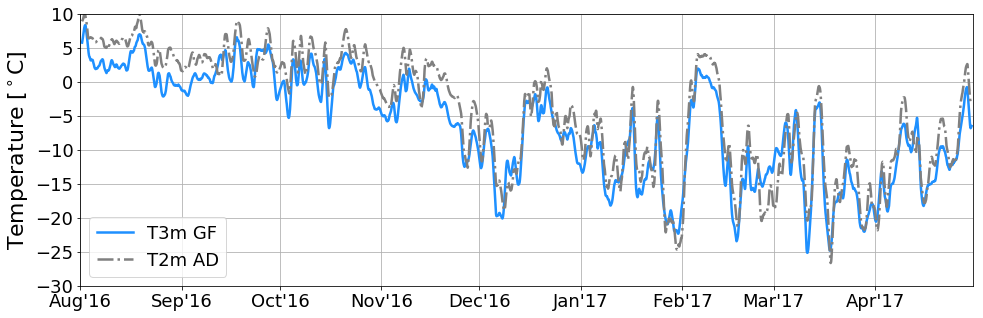

In [51]:
f9, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = (16,5))
# maxGF = max(GF_data.T3m_minutt_Avg)
# date_maxGF = GF_data.T3m_minutt_Avg.idxmax()
# date_minGF = GF_data.T3m_minutt_Avg.idxmin()
# print(date_maxGF,date_minGF)
# maxAVD = max(AVD_data.T2m_PT1000_Avg)
# date_maxAVD = AVD_data.T2m_PT1000_Avg.idxmax()
# date_minAVD = AVD_data.T2m_PT1000_Avg.idxmin()
# print(date_maxAVD,date_minAVD)


dTind = GF_data.index
xticks=[]
dates = ['2016-08-01 00:00:00','2016-09-01 00:00:00','2016-10-01 00:00:00','2016-11-01 00:00:00','2016-12-01 00:00:00',
        '2017-01-01 00:00:00','2017-02-01 00:00:00','2017-03-01 00:00:00','2017-04-01 00:00:00',]
for counter, value in enumerate(dTind):
    if str(value) in dates:
        xticks.append(counter)

ax1.grid()
data = pd.DataFrame.from_records({"GF":GF_data.T3m_minutt_Avg.tolist(),'AD':AVD_data.T2m_PT1000_Avg.tolist()})
ax1.plot(data.index, data.GF.rolling(24,center=True).mean(),color="#1E90FF",linestyle='-',linewidth=2.5, label = "T3m GF")
ax1.plot(data.index, data.AD.rolling(24,center=True).mean(),color ="#808080",linestyle='-.', linewidth=2.5, label = "T2m AD")
ax1.set_ylabel("Temperature [$^\circ$C]",fontsize =22)
ax1.set_ylim((-30,10))
ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
ax1.set_yticks(np.arange(-30,11,5))
ax1.set_xlim((0,len(data.index)))
ax1.set_xticks(ticks=xticks)
ax1.set_xticklabels(['Aug\'16','Sep\'16','Oct\'16','Nov\'16','Dec\'16',
        'Jan\'17','Feb\'17','Mar\'17','Apr\'17'])
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18)
#TEST: Customize xticklabels, want to set them in the middle between majorticks.
# ax1.set_xticklabels('')
# ax1.set_xticks(ticks=xticks, minor = True)
# ax1.set_xticklabels(['Aug\'16','Sep\'16','Oct\'16','Nov\'16','Dec\'16',
#         'Jan\'17','Feb\'17','Mar\'17','Apr\'17'], minor = True)
# f9.autofmt_xdate()
plt.savefig('./figures/timel_T3mGF_T2mAD.png')
plt.savefig('./figures/timel_T3mGF_T2mAD.eps')

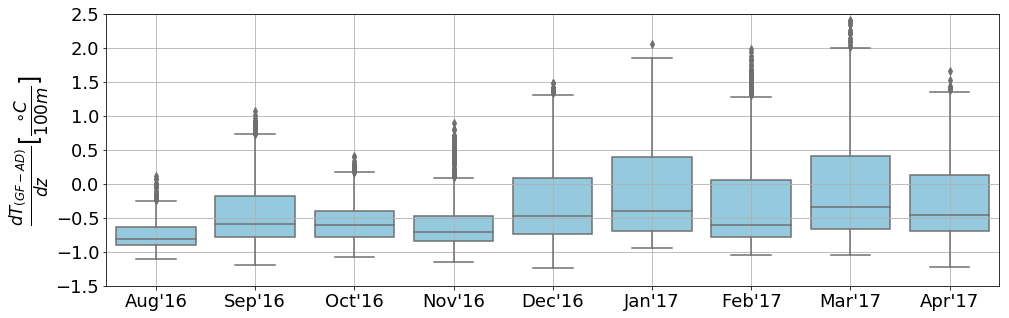

In [49]:
f9, (ax2) = plt.subplots(nrows = 1, ncols = 1, figsize = (16,5))
sns.boxplot(Tgrad_GFAVD_3m2mRot.index.strftime("%b\'%y"),Tgrad_GFAVD_3m2mRot,ax=ax2,
 color='skyblue', saturation=0.75)
ax2.set_ylabel(r'$\frac{dT_{(GF-AD)}}{dz} [\frac{\circ C}{100 m}]$', fontsize=24)
ax2.tick_params(labelsize=18)
ax2.set_ylim([-1.5,2.5])
ax2.yaxis.set_major_locator(plt.MaxNLocator(9))
# ax2.set_yticklabels([-1.5,-1.0,-0.5,0,0.5,1,1.5,2,2.5])
ax2.grid()

plt.savefig('./figures/Tgrad_boxpl_T3mGF_T2mAD.png')
plt.savefig('./figures/Tgrad_boxpl_T3mGF_T2mAD.eps')




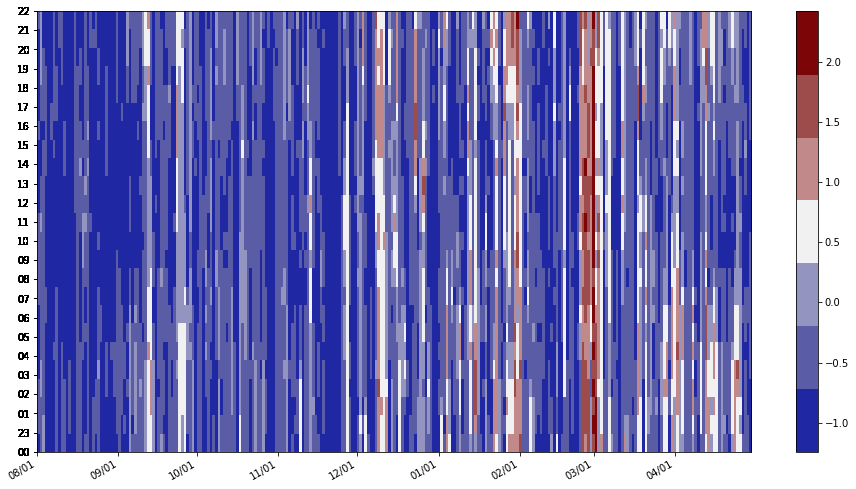

In [6]:
data = pd.DataFrame()
data['Date']=Tgrad_GFAVD_3m2mRot.index.date
data['Time']=Tgrad_GFAVD_3m2mRot.index.strftime("%H")
data['Tgrad']=Tgrad_GFAVD_3m2mRot.values
data["datenum"]=mdates.date2num(data["Date"])

C = data.pivot(index='Time', columns='Date', values='Tgrad')
# print(C.head())
fig, ax = plt.subplots(figsize = (16,9))
# cmap = colors.ListedColormap(["#1F28A2","#2C329F","#363A9E","#3E429E","#464A9F",
#                               "#4E51A2","#5659A4","#5E61A7","#6668AB","#6F70AE",
#                               "#7779B2","#8081B7","#898ABB","#9394C0","#9D9EC6",
#                               "#A7A8CB","#B3B4D1","#C0C0D8","#CECFDF","#E1E1E9",
#                               "#E9DFDF","#E1CBCB","#DABBBB","#D3ADAD","#CDA0A0",
#                               "#C79494","#C18989","#BB7F7F","#B67475","#B06B6B",
#                               "#AB6162","#A55858","#A04F4F","#9B4647","#953D3E",
#                               "#903435","#8B2B2C","#862122","#811617","#7C0607"])
# cmap = colors.ListedColormap(["#1F28A2","#363B9E","#474BA0","#585AA5","#686AAB",
#                               "#797BB4","#8C8DBD","#A0A1C8","#B8B9D4","#D6D6E3",
#                               "#E5D4D4","#D6B2B3","#C99899","#BD8282","#B26D6D",
#                               "#A65A5A","#9C4848","#913536","#862222","#7C0607"])
# cmap = colors.ListedColormap(["#1F28A2","#494CA0","#6C6EAD","#9394C0","#C4C5DA",
#                               "#DCC0C0","#C18989","#A95E5E","#923738","#7C0607"])
cmap = colors.ListedColormap(["#1F28A2","#5A5DA6","#9394C0","#F1F1F1","#C18989","#9D4B4B","#7C0607"])



pl = ax.imshow(C,aspect = 'auto',
               cmap = cmap,
               extent=[data["datenum"].iloc[0],data["datenum"].iloc[-1],data["Time"].iloc[0],data["Time"].iloc[-1]],
               origin = "lower")
ax.set_yticks(data["Time"])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d") )
fig.autofmt_xdate()
plt.colorbar(pl)


